# Instalar bibliotecas necesarias

In [1]:
#pip install torch torchvision torchaudio

In [2]:
#pip install tqdm

# Pre procesamiento de los datos

### Obtención de dimensiones y modos de color

Dimensiones y modos de color de las imágenes de entrenamiento:
[((400, 224), 'RGB'), ((400, 268), 'RGB'), ((400, 294), 'RGB'), ((400, 266), 'RGB'), ((400, 166), 'RGB'), ((400, 286), 'RGB'), ((400, 265), 'RGB'), ((400, 266), 'RGB'), ((400, 272), 'RGB'), ((400, 293), 'RGB')]

Dimensiones y modos de color de las imágenes de prueba:
[((400, 205), 'RGB'), ((400, 266), 'RGB'), ((400, 300), 'RGB'), ((400, 225), 'RGB'), ((400, 293), 'RGB'), ((400, 225), 'RGB'), ((400, 266), 'RGB'), ((400, 300), 'RGB'), ((400, 266), 'RGB'), ((400, 266), 'RGB')]

Dimensión más común: (400, 266)
Modo de color más común: RGB


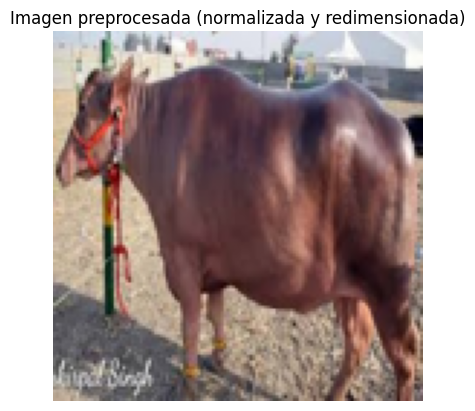

In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Rutas a los directorios de datos
train_dir = r'C:\Users\Jesus\Desktop\dataset\train'
test_dir = r'C:\Users\Jesus\Desktop\dataset\test'

def get_image_dimensions_and_channels(image_dir):
    dimensions = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    dimensions.append((img.size, img.mode))
    return dimensions

# Obtener dimensiones y modos de color para las imágenes de entrenamiento y prueba
train_dimensions = get_image_dimensions_and_channels(train_dir)
test_dimensions = get_image_dimensions_and_channels(test_dir)

# Visualizar dimensiones y modos de color
print("Dimensiones y modos de color de las imágenes de entrenamiento:")
print(train_dimensions[:10])  # Muestra solo las primeras 10 para no saturar la salida

print("\nDimensiones y modos de color de las imágenes de prueba:")
print(test_dimensions[:10])

# Buscar dimensiones y modos de color más comunes
train_dims, train_modes = zip(*train_dimensions)
test_dims, test_modes = zip(*test_dimensions)

common_dim = max(set(train_dims + test_dims), key=(train_dims + test_dims).count)
common_mode = max(set(train_modes + test_modes), key=(train_modes + test_modes).count)

print(f"\nDimensión más común: {common_dim}")
print(f"Modo de color más común: {common_mode}")

# Configuración para la transformación
resize_dim = (128, 128)
common_mode = "RGB"  # Usamos RGB para asegurar 3 canales

def preprocess_image(img_path, resize_dim, common_mode):
    with Image.open(img_path) as img:
        if img.mode != common_mode:
            img = img.convert(common_mode)
        img = img.resize(resize_dim)
        img = np.array(img) / 255.0  # Normalizar entre 0 y 1
    return img

# Visualizar ejemplo de imagen preprocesada
sample_img_path = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
preprocessed_img = preprocess_image(sample_img_path, resize_dim, common_mode)

plt.imshow(preprocessed_img)
plt.title("Imagen preprocesada (normalizada y redimensionada)")
plt.axis("off")
plt.show()


### Preprocesamiento de una imagen de ejemplo

Número de imágenes de entrenamiento: 3200
Número de imágenes de prueba: 800
Dimensiones de las imágenes: (128, 128, 3)
Etiquetas: {'Buffalo': 0, 'Elephant': 1, 'Rhino': 2, 'Zebra': 3}


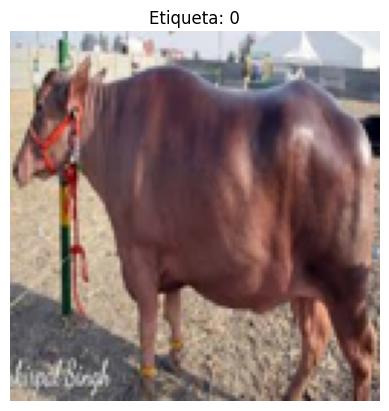

In [4]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Rutas a los directorios de datos
train_dir = r'C:\Users\Jesus\Desktop\dataset\train'
test_dir = r'C:\Users\Jesus\Desktop\dataset\test'

resize_dim = (128, 128)
common_mode = "RGB"

def preprocess_images_from_directory(directory, resize_dim, common_mode):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        label = os.path.basename(root)
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    if img.mode != common_mode:
                        img = img.convert(common_mode)
                    img = img.resize(resize_dim)
                    img = np.array(img) / 255.0  # Normalizar entre 0 y 1
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Preprocesar imágenes de entrenamiento y prueba
X_train, y_train = preprocess_images_from_directory(train_dir, resize_dim, common_mode)
X_test, y_test = preprocess_images_from_directory(test_dir, resize_dim, common_mode)

# Convertir etiquetas en categorías numéricas
label_to_index = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train = np.array([label_to_index[label] for label in y_train])
y_test = np.array([label_to_index[label] for label in y_test])

# Visualizar información del dataset preprocesado
print(f"Número de imágenes de entrenamiento: {X_train.shape[0]}")
print(f"Número de imágenes de prueba: {X_test.shape[0]}")
print(f"Dimensiones de las imágenes: {X_train.shape[1:]}")
print(f"Etiquetas: {label_to_index}")

# Ejemplo de imagen preprocesada y su etiqueta
plt.imshow(X_train[0])
plt.title(f"Etiqueta: {y_train[0]}")
plt.axis("off")
plt.show()


# Configuración de la GPU y limpieza de caché

In [5]:
import torch

# Configuración de la GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Limpiar el caché de la GPU
torch.cuda.empty_cache()


# Importación de librerías y configuración de rutas

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import copy
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Rutas a los directorios de datos
train_dir = r'C:\Users\Jesus\Desktop\dataset\train'
test_dir = r'C:\Users\Jesus\Desktop\dataset\test'

# Definición de las transformaciones para los datos

In [7]:
# Transformaciones para la data de entrenamiento y prueba
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Carga de los datos y división en conjuntos de entrenamiento y validación

In [8]:
# Data loader
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# División del conjunto de datos de entrenamiento en entrenamiento y validación
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verificar la carga de imágenes y carpetas
print(f'Clases encontradas en entrenamiento: {full_train_dataset.classes}')
print(f'Número de imágenes en entrenamiento: {len(train_dataset)}')
print(f'Número de imágenes en validación: {len(val_dataset)}')
print(f'Número de imágenes en prueba: {len(test_dataset)}')

Clases encontradas en entrenamiento: ['Buffalo', 'Elephant', 'Rhino', 'Zebra']
Número de imágenes en entrenamiento: 2240
Número de imágenes en validación: 960
Número de imágenes en prueba: 800


# Configuración del modelo preentrenado ResNet18

In [9]:
# Cargar el modelo ResNet18 preentrenado
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar las capas del modelo
for param in model.parameters():
    param.requires_grad = False

# Descongelar las últimas dos capas del modelo
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True

# Modificar la última capa del modelo para adaptarse a nuestro problema
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, len(full_train_dataset.classes))
)
model = model.to(device)


# Configuración del optimizador y función de pérdida

In [10]:
# Configuración del optimizador y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

#  Implementación de Early Stopping

In [11]:
# Implementación de Early Stopping con paciencia de 10
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=10, min_delta=0.001)


# Función para calcular la precisión

In [12]:
# Función para calcular la precisión
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data).item() / len(labels)

# Entrenamiento del modelo

In [13]:
# Entrenamiento del modelo
def train_model_with_accuracy(model, criterion, optimizer, num_epochs=100):
    print("Training model...")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        start_time = time.time()
        
        # Entrenamiento
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validación
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)
        
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_corrects / len(val_dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)
        
        # Early Stopping
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        # Guardar el mejor modelo
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} - "
              f"Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f} - "
              f"Time: {time.time() - start_time:.2f}s")
    
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Entrenar el modelo
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_accuracy(
    model, criterion, optimizer, num_epochs=100
)

Training model...


Epoch 1/100 - Train Loss: 1.4144 Train Acc: 0.2924 - Val Loss: 1.2604 Val Acc: 0.5208 - Time: 30.03s


Epoch 2/100 - Train Loss: 1.2789 Train Acc: 0.4067 - Val Loss: 1.1185 Val Acc: 0.6823 - Time: 29.63s


Epoch 3/100 - Train Loss: 1.1395 Train Acc: 0.5201 - Val Loss: 0.9796 Val Acc: 0.7667 - Time: 29.80s


Epoch 4/100 - Train Loss: 1.0323 Train Acc: 0.5839 - Val Loss: 0.8652 Val Acc: 0.8052 - Time: 30.22s


Epoch 5/100 - Train Loss: 0.9231 Train Acc: 0.6397 - Val Loss: 0.7815 Val Acc: 0.8031 - Time: 29.83s


Epoch 6/100 - Train Loss: 0.8412 Train Acc: 0.6884 - Val Loss: 0.6911 Val Acc: 0.8250 - Time: 29.53s


Epoch 7/100 - Train Loss: 0.7560 Train Acc: 0.7295 - Val Loss: 0.6368 Val Acc: 0.8365 - Time: 29.31s


Epoch 8/100 - Train Loss: 0.6871 Train Acc: 0.7768 - Val Loss: 0.5660 Val Acc: 0.8302 - Time: 29.33s


Epoch 9/100 - Train Loss: 0.6371 Train Acc: 0.7884 - Val Loss: 0.5053 Val Acc: 0.8500 - Time: 30.36s


Epoch 10/100 - Train Loss: 0.5683 Train Acc: 0.8134 - Val Loss: 0.4914 Val Acc: 0.8458 - Time: 29.42s


Epoch 11/100 - Train Loss: 0.5284 Train Acc: 0.8272 - Val Loss: 0.4181 Val Acc: 0.8760 - Time: 29.19s


Epoch 12/100 - Train Loss: 0.5002 Train Acc: 0.8259 - Val Loss: 0.3961 Val Acc: 0.8823 - Time: 29.03s


Epoch 13/100 - Train Loss: 0.4821 Train Acc: 0.8326 - Val Loss: 0.3693 Val Acc: 0.8812 - Time: 29.10s


Epoch 14/100 - Train Loss: 0.4593 Train Acc: 0.8415 - Val Loss: 0.3810 Val Acc: 0.8740 - Time: 29.37s


Epoch 15/100 - Train Loss: 0.4346 Train Acc: 0.8455 - Val Loss: 0.3469 Val Acc: 0.8729 - Time: 29.34s


Epoch 16/100 - Train Loss: 0.4107 Train Acc: 0.8621 - Val Loss: 0.3304 Val Acc: 0.8823 - Time: 29.23s


Epoch 17/100 - Train Loss: 0.3710 Train Acc: 0.8598 - Val Loss: 0.3277 Val Acc: 0.8729 - Time: 29.23s


Epoch 18/100 - Train Loss: 0.3771 Train Acc: 0.8603 - Val Loss: 0.3324 Val Acc: 0.8688 - Time: 29.03s


Epoch 19/100 - Train Loss: 0.3648 Train Acc: 0.8741 - Val Loss: 0.3150 Val Acc: 0.8781 - Time: 29.43s


Epoch 20/100 - Train Loss: 0.3675 Train Acc: 0.8621 - Val Loss: 0.2879 Val Acc: 0.8865 - Time: 29.12s


Epoch 21/100 - Train Loss: 0.3458 Train Acc: 0.8741 - Val Loss: 0.2872 Val Acc: 0.8938 - Time: 29.29s


Epoch 22/100 - Train Loss: 0.3293 Train Acc: 0.8768 - Val Loss: 0.2665 Val Acc: 0.9010 - Time: 29.04s


Epoch 23/100 - Train Loss: 0.3328 Train Acc: 0.8799 - Val Loss: 0.2991 Val Acc: 0.8854 - Time: 29.30s


Epoch 24/100 - Train Loss: 0.3294 Train Acc: 0.8817 - Val Loss: 0.2666 Val Acc: 0.8958 - Time: 29.21s


Epoch 25/100 - Train Loss: 0.3124 Train Acc: 0.8795 - Val Loss: 0.2302 Val Acc: 0.9187 - Time: 29.04s


Epoch 26/100 - Train Loss: 0.2927 Train Acc: 0.8933 - Val Loss: 0.2810 Val Acc: 0.8906 - Time: 29.12s


Epoch 27/100 - Train Loss: 0.3026 Train Acc: 0.8879 - Val Loss: 0.2751 Val Acc: 0.8906 - Time: 29.10s


Epoch 28/100 - Train Loss: 0.2757 Train Acc: 0.8951 - Val Loss: 0.2730 Val Acc: 0.8979 - Time: 29.10s


Epoch 29/100 - Train Loss: 0.3059 Train Acc: 0.8871 - Val Loss: 0.2419 Val Acc: 0.9000 - Time: 29.05s


Epoch 30/100 - Train Loss: 0.2843 Train Acc: 0.8893 - Val Loss: 0.2316 Val Acc: 0.9094 - Time: 29.30s


Epoch 31/100 - Train Loss: 0.2660 Train Acc: 0.9022 - Val Loss: 0.2658 Val Acc: 0.8958 - Time: 29.05s


Epoch 32/100 - Train Loss: 0.2670 Train Acc: 0.8969 - Val Loss: 0.2440 Val Acc: 0.9021 - Time: 29.32s


Epoch 33/100 - Train Loss: 0.2591 Train Acc: 0.9000 - Val Loss: 0.2436 Val Acc: 0.9073 - Time: 29.06s


Epoch 34/100 - Train Loss: 0.2630 Train Acc: 0.9076 - Val Loss: 0.2267 Val Acc: 0.9156 - Time: 29.22s


Epoch 35/100 - Train Loss: 0.2733 Train Acc: 0.8991 - Val Loss: 0.2212 Val Acc: 0.9083 - Time: 28.82s


Epoch 36/100 - Train Loss: 0.2793 Train Acc: 0.8951 - Val Loss: 0.2311 Val Acc: 0.9156 - Time: 29.14s


Epoch 37/100 - Train Loss: 0.2434 Train Acc: 0.9094 - Val Loss: 0.2550 Val Acc: 0.8990 - Time: 29.20s


Epoch 38/100 - Train Loss: 0.2754 Train Acc: 0.8996 - Val Loss: 0.2457 Val Acc: 0.8958 - Time: 29.12s


Epoch 39/100 - Train Loss: 0.2695 Train Acc: 0.8906 - Val Loss: 0.2464 Val Acc: 0.8979 - Time: 29.12s


Epoch 40/100 - Train Loss: 0.2454 Train Acc: 0.9049 - Val Loss: 0.2440 Val Acc: 0.9042 - Time: 29.21s


Epoch 41/100 - Train Loss: 0.2532 Train Acc: 0.9018 - Val Loss: 0.2351 Val Acc: 0.9021 - Time: 29.14s


Epoch 42/100 - Train Loss: 0.2476 Train Acc: 0.9027 - Val Loss: 0.2155 Val Acc: 0.9156 - Time: 29.12s


Epoch 43/100 - Train Loss: 0.2507 Train Acc: 0.9071 - Val Loss: 0.2323 Val Acc: 0.9031 - Time: 29.16s


Epoch 44/100 - Train Loss: 0.2240 Train Acc: 0.9161 - Val Loss: 0.2048 Val Acc: 0.9010 - Time: 29.33s


Epoch 45/100 - Train Loss: 0.2472 Train Acc: 0.9071 - Val Loss: 0.2073 Val Acc: 0.9219 - Time: 29.17s


Epoch 46/100 - Train Loss: 0.2113 Train Acc: 0.9174 - Val Loss: 0.2326 Val Acc: 0.9104 - Time: 29.14s


Epoch 47/100 - Train Loss: 0.2528 Train Acc: 0.9049 - Val Loss: 0.2326 Val Acc: 0.8958 - Time: 29.10s


Epoch 48/100 - Train Loss: 0.2286 Train Acc: 0.9076 - Val Loss: 0.1990 Val Acc: 0.9208 - Time: 29.20s


Epoch 49/100 - Train Loss: 0.2271 Train Acc: 0.9161 - Val Loss: 0.1906 Val Acc: 0.9281 - Time: 29.26s


Epoch 50/100 - Train Loss: 0.2361 Train Acc: 0.9049 - Val Loss: 0.2219 Val Acc: 0.9073 - Time: 29.22s


Epoch 51/100 - Train Loss: 0.2076 Train Acc: 0.9228 - Val Loss: 0.2253 Val Acc: 0.9104 - Time: 29.68s


Epoch 52/100 - Train Loss: 0.2307 Train Acc: 0.9085 - Val Loss: 0.2119 Val Acc: 0.9167 - Time: 29.07s


Epoch 53/100 - Train Loss: 0.2278 Train Acc: 0.9112 - Val Loss: 0.2240 Val Acc: 0.9135 - Time: 29.04s


Epoch 54/100 - Train Loss: 0.2218 Train Acc: 0.9112 - Val Loss: 0.2300 Val Acc: 0.9115 - Time: 29.13s


Epoch 55/100 - Train Loss: 0.2315 Train Acc: 0.9134 - Val Loss: 0.2181 Val Acc: 0.9031 - Time: 29.25s


Epoch 56/100 - Train Loss: 0.2116 Train Acc: 0.9174 - Val Loss: 0.2071 Val Acc: 0.9187 - Time: 29.20s


Epoch 57/100 - Train Loss: 0.2083 Train Acc: 0.9246 - Val Loss: 0.2043 Val Acc: 0.9156 - Time: 29.13s


Epoch 58/100 - Train Loss: 0.2001 Train Acc: 0.9214 - Val Loss: 0.2279 Val Acc: 0.9083 - Time: 29.13s


Early stopping


# Graficar Pérdida y Precisión

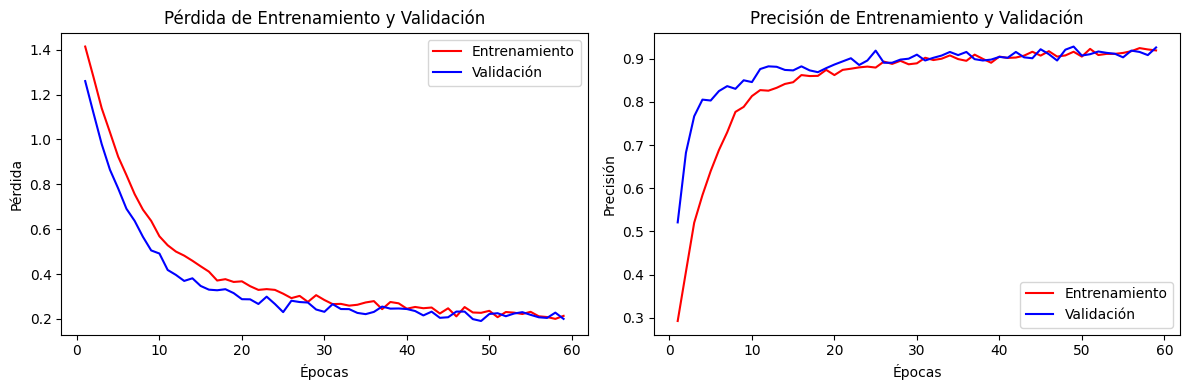

In [14]:
# Graficar las pérdidas y precisiones de entrenamiento y validación
def plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Entrenamiento')
    plt.plot(epochs, val_losses, 'b', label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida de Entrenamiento y Validación')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Entrenamiento')
    plt.plot(epochs, val_accuracies, 'b', label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión de Entrenamiento y Validación')
    
    plt.tight_layout()
    plt.show()

plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

## Metricas

Accuracy: 0.9912
Precision: 0.9913
Recall: 0.9912
F1 Score: 0.9912
Confusion Matrix:
[[198   0   1   1]
 [  0 198   2   0]
 [  1   1 197   1]
 [  0   0   0 200]]
True Negatives: 198
False Negatives: 0
True Positives: 198
False Positives: 0


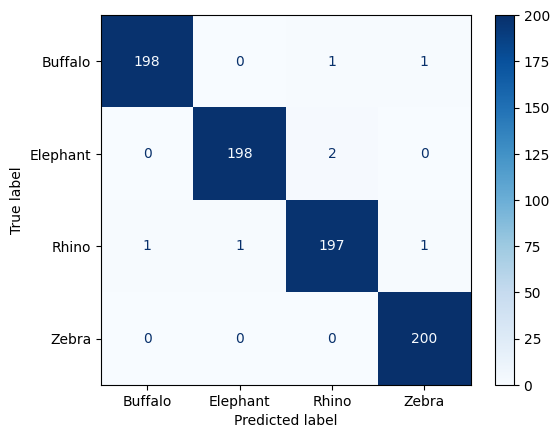

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Función para calcular y mostrar las métricas
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)
    
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_train_dataset.classes)
    disp.plot(cmap='Blues')
    plt.show()

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader)


# Comparativa real vs prediccion

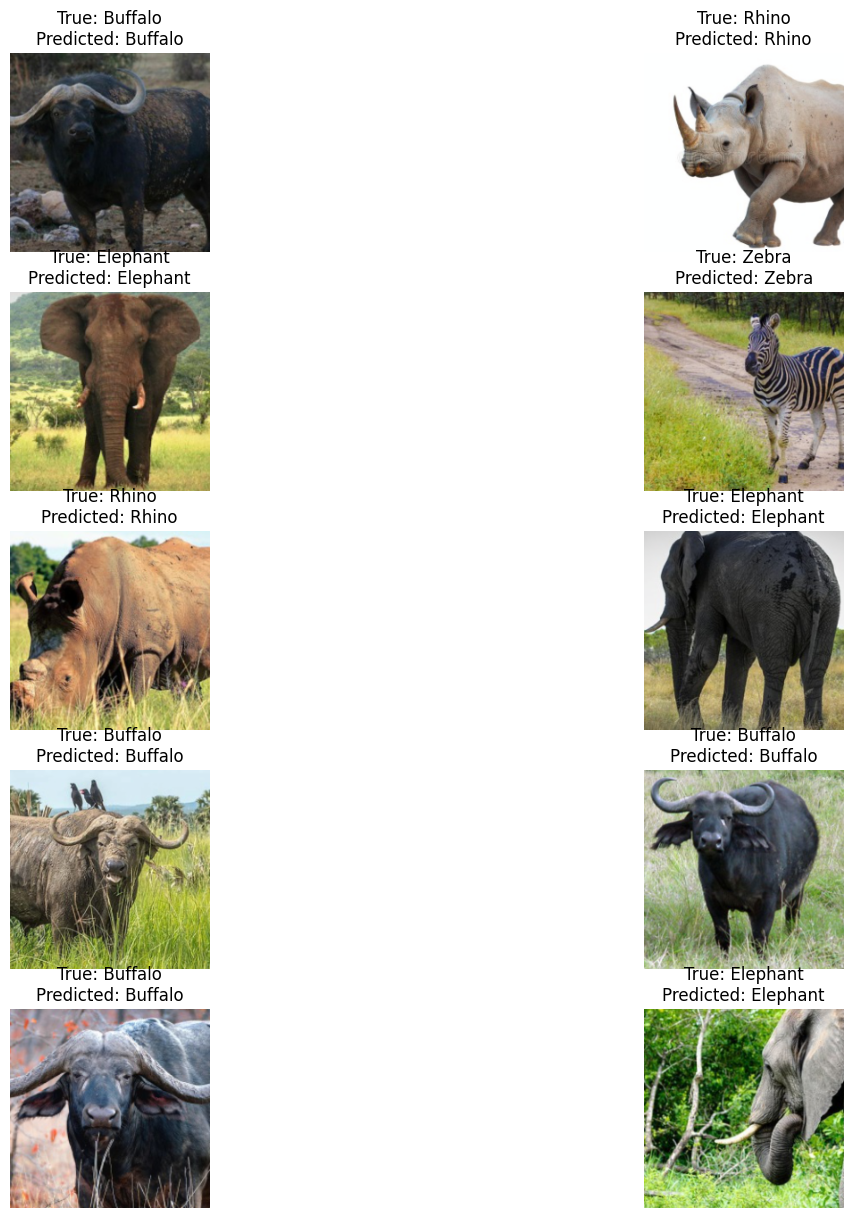

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Función para mostrar imagen con predicción
def imshow_with_prediction(img, true_label, predicted_label):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

# Función para mostrar comparativa de imágenes originales vs predicción
def compare_predictions(model, test_loader, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
    
    # Seleccionar aleatoriamente un número de imágenes
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                all_images.append(inputs.cpu().data[j])
                all_labels.append(labels[j])
                all_preds.append(preds[j])
    
    random_indices = random.sample(range(len(all_images)), num_images)
    
    for idx in random_indices:
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        
        imshow_with_prediction(all_images[idx], 
                               full_train_dataset.classes[all_labels[idx]], 
                               full_train_dataset.classes[all_preds[idx]])
        
        if images_so_far == num_images:
            break

compare_predictions(model, test_loader, num_images=10)

